In [1]:
from src.v1.symbolic import Var
from src.v2.nesting import Model, adda, addf, addsolver, geteqs
from src.v2.nesting import INTER, END, SOLVER, RefNode
from graph.graphview import render_tree, digraph_repr, drawfull, draw, tree_incidence
from src.v1tree.operatorsold import merge_pure
from anytree import LevelOrderIter
from src.v1tree.notation import generate_execution, graphs_from_incidence, make_acyclic, default_sequence
from src.v1tree.notationtree import notation_from_tree, all_vars_from_incidence
import networkx as nx

In [2]:
x,c,d,z = Var('x'), Var('c'), Var('d'), Var('z')

### a) Top-down: we build up the tree as we go

In [3]:
model = Model()
m = RefNode(name='/', ref=model)
y = adda(m, 'y', x)
a = adda(m, 'a', c+y)
b = adda(m, 'b', a)
addf(m, b+d)
solver = addsolver(m) 
addf(solver, a+d)
solver.setsolvefor([d]) 
e = adda(m, 'e', c+b)

### b) Bottom-up: we create all the leaves and then merge them

In [4]:
model = Model()
m = RefNode(name='/', ref=model)
y = adda(m, 'y', x)
a = adda(m, 'a', c+y)
b = adda(m, 'b', a+z)
r_3 = addf(m, b+d)
r_4 = addf(m, a+d)
s2 = addsolver(m, [], [(r_4, d)], name='s2')
e = adda(m, 'e', c+b)

$r_3$ has multiple "true" inputs: c and d (since b is an elimination variable), and we pick with respect to which one we solve for projected feasability

### c) bottom-up reset

In [5]:
f_0, f_1, f_2 = geteqs(m, [y,a,b])

In [6]:
s1 = addsolver(m, [f_0, f_1, f_2, s2], [(r_3, c)], name='s1') # could still be cyclic at this point

## Generate graphs from incidence structure

In [7]:
eqs,sparsity,dout,_ = model.data_structures()

In [8]:
sequence_m = default_sequence(m)

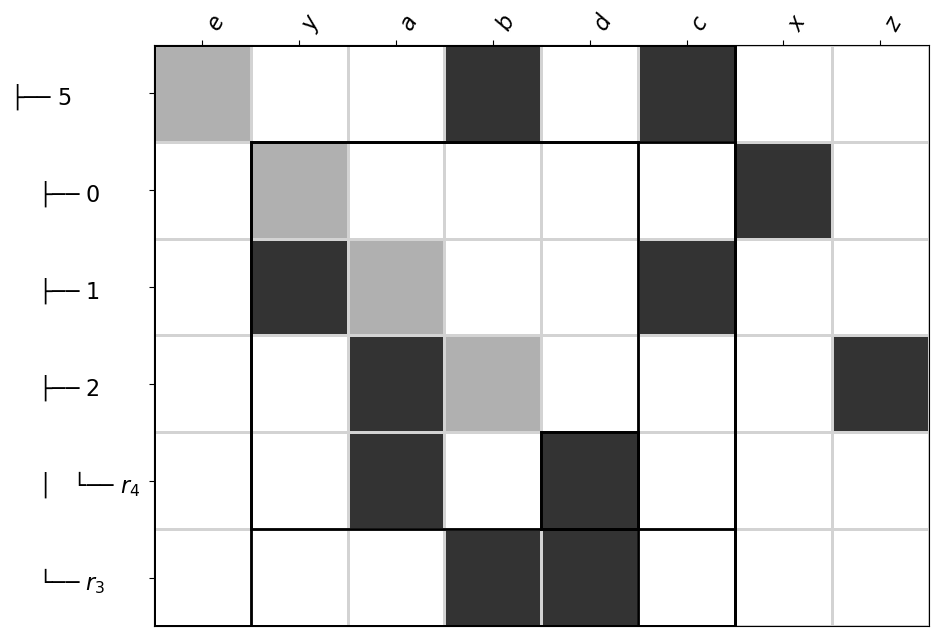

In [9]:
fig, ax = tree_incidence(m, sparsity, model.outset, sequence_m, figsize=(10,10));
#plt.sca(ax)
#plt.savefig('figures/balloon_user.png', dpi=600, bbox_inches='tight')

In [10]:
G, _ = digraph_repr(sparsity, dout, intermediary=True)

In [14]:
merge_order = [node for node in LevelOrderIter(s1) if node.node_type==SOLVER][::-1]

In [ ]:
m.outset

</>

In [20]:
newG = G
graphs = dict()
for elt in merge_order:
    print(elt.children)
    newG, graphs = merge_pure(newG, elt.children, elt, graphs=graphs, solvefor=m.outset)

(r_4,)
(f_0, f_1, f_2, s2, r_3)


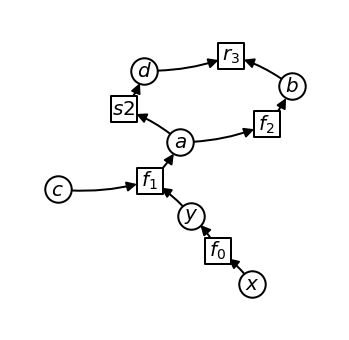

In [21]:
drawfull(graphs[s1], eqs)

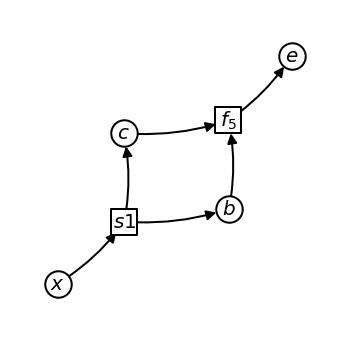

In [22]:
drawfull(newG, eqs)

## Fixing cyclic graphs

In [23]:
def standardize(elt):
    if elt.children:
        return elt.children
    else:
        assert elt.node_type == INTER
        elt.node_type = END
        return [elt]

In [24]:
scc = sort_mdf(graphs[s1], eqs)

In [25]:
mdf = False
for solver in merge_order:
    scc = sort_mdf(graphs[solver], eqs)
    order = []
    for cc in scc:
        if len(cc) == 1:
            order += [next(iter(cc))]
        else:
            stcc = [elt for node in cc for elt in standardize(cc)]
            if mdf:
                order += [addsolver(solver, stcc)]
            else:
                order += stcc
                for node in stcc:
                    node.parent = solver

In [26]:
render_tree(s1)

s1              
├── s2          
│   └── r_4     
├── f_0         
├── f_1         
├── f_2         
└── r_3         


# Draw tree

In [32]:
edges = [(node.parent, node) for node in LevelOrderIter(s1.node) if node.parent]

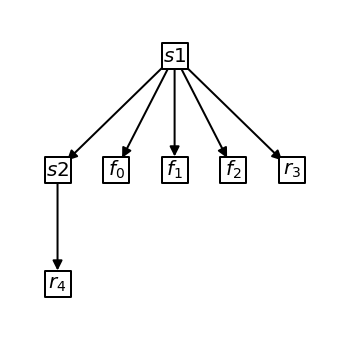

In [37]:
draw(nx.DiGraph(edges), prog='dot', latexlabels=False);